In [1]:
    import torch
    print(f"PyTorch có sử dụng CUDA (GPU) không: {torch.cuda.is_available()}")
    print(f"Tên thiết bị CUDA: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'Không có'}")

PyTorch có sử dụng CUDA (GPU) không: True
Tên thiết bị CUDA: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [2]:
import sys
print(sys.executable)

c:\Users\chong\AppData\Local\Programs\Python\Python313\python.exe


In [3]:
!pip show accelerate
!pip show transformers

Name: accelerate
Version: 1.11.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: C:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages
Requires: huggingface_hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 
Name: transformers
Version: 4.57.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: C:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [4]:
# Import các thư viện chính
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
import numpy as np
import evaluate
import matplotlib.pyplot as plt

c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Tải tập dữ liệu IMDb
print("Đang tải tập dữ liệu IMDb...")
dataset = load_dataset("imdb")
print("Đã tải xong tập dữ liệu.")
print("\nĐang lấy tập con nhỏ từ tập dữ liệu để huấn luyện và kiểm tra nhanh...")
dataset["train"] = dataset["train"].select(range(1000)) # Chỉ lấy 1000 mẫu cho huấn luyện
dataset["test"] = dataset["test"].select(range(100))   # Chỉ lấy 100 mẫu cho kiểm tra
print("Đã lấy tập con dữ liệu.")
# In cấu trúc dataset
print("\nCấu trúc tập dữ liệu:")
print(dataset)

Đang tải tập dữ liệu IMDb...
Đã tải xong tập dữ liệu.

Đang lấy tập con nhỏ từ tập dữ liệu để huấn luyện và kiểm tra nhanh...
Đã lấy tập con dữ liệu.

Cấu trúc tập dữ liệu:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 100
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [6]:
# Chọn tên mô hình
model_name = "distilbert-base-uncased"

# Tải tokenizer
print(f"\nĐang tải tokenizer cho mô hình: {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
print("Đã tải xong tokenizer.")

# Tải mô hình cho phân loại chuỗi (2 nhãn)
print(f"Đang tải mô hình đã huấn luyện trước cho phân loại chuỗi: {model_name}...")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
print("Đã tải xong mô hình.")


Đang tải tokenizer cho mô hình: distilbert-base-uncased...
Đã tải xong tokenizer.
Đang tải mô hình đã huấn luyện trước cho phân loại chuỗi: distilbert-base-uncased...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Đã tải xong mô hình.


In [7]:
# Hàm token hóa văn bản
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

# Áp dụng token hóa
print("\nĐang token hóa tập dữ liệu...")
tokenized_datasets = dataset.map(tokenize_function, batched=True)
print("Đã token hóa xong tập dữ liệu.")

# Làm sạch và định dạng lại dataset
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# In cấu trúc dataset sau tiền xử lý
print("\nCấu trúc tập dữ liệu sau tiền xử lý:")
print(tokenized_datasets)


Đang token hóa tập dữ liệu...


Map: 100%|██████████| 100/100 [00:00<00:00, 1186.22 examples/s]


Đã token hóa xong tập dữ liệu.

Cấu trúc tập dữ liệu sau tiền xử lý:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 100
    })
    unsupervised: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})


In [8]:
# Định nghĩa các tham số huấn luyện
print("\nĐang định nghĩa các đối số huấn luyện...")
training_args = TrainingArguments(
    output_dir="./results",                   # Thư mục để lưu kết quả và các checkpoint
    eval_strategy="epoch",                    # Thực hiện đánh giá sau mỗi epoch huấn luyện
    learning_rate=2e-5,                       # Tốc độ học ban đầu
    per_device_train_batch_size=4,            # Đã giảm xuống 4 để tối ưu VRAM hơn nữa
    per_device_eval_batch_size=4,             # Đã giảm xuống 4 để tối ưu VRAM hơn nữa
    gradient_accumulation_steps=4,            # Tích lũy gradient qua 4 bước để có batch size hiệu quả là 4*4=16
    num_train_epochs=3,                       # Số lượng epoch huấn luyện
    weight_decay=0.01,                        # Giá trị giảm trọng số để tránh overfitting
    logging_dir='./logs',                     # Thư mục lưu log cho TensorBoard
    logging_steps=500,                        # Ghi log sau mỗi 500 bước
    save_strategy="epoch",                    # Lưu mô hình sau mỗi epoch
    load_best_model_at_end=True,            
    metric_for_best_model="accuracy",         # Chỉ số được sử dụng để xác định mô hình tốt nhất
    push_to_hub=False,                        # Không đẩy mô hình lên Hugging Face Hub
    fp16=True,                                # Bật Mixed Precision Training (FP16) để giảm sử dụng VRAM và tăng tốc độ
)
print("Đã định nghĩa các đối số huấn luyện.")

# Tải chỉ số "accuracy" (độ chính xác) từ thư viện evaluate
print("\nĐang định nghĩa hàm tính toán chỉ số...")
metric = evaluate.load("accuracy")

# Định nghĩa hàm compute_metrics để tính toán độ chính xác trong quá trình đánh giá
def compute_metrics(eval_pred):
    logits, labels = eval_pred # logits là đầu ra raw của mô hình, labels là nhãn thật
    predictions = np.argmax(logits, axis=-1) # Chuyển logits thành dự đoán nhãn bằng cách lấy chỉ số lớn nhất
    return metric.compute(predictions=predictions, references=labels) # Tính độ chính xác

print("Đã định nghĩa hàm tính toán chỉ số.")


Đang định nghĩa các đối số huấn luyện...
Đã định nghĩa các đối số huấn luyện.

Đang định nghĩa hàm tính toán chỉ số...
Đã định nghĩa hàm tính toán chỉ số.


In [9]:
# Khởi tạo đối tượng Trainer
print("\nĐang khởi tạo Trainer...")
trainer = Trainer(
    model=model,                              # Mô hình cần huấn luyện
    args=training_args,                       # Các đối số huấn luyện đã định nghĩa
    train_dataset=tokenized_datasets["train"], # Tập dữ liệu huấn luyện
    eval_dataset=tokenized_datasets["test"],   # Tập dữ liệu để đánh giá trong quá trình huấn luyện
    tokenizer=tokenizer,                      # Tokenizer đã sử dụng
    compute_metrics=compute_metrics,          # Hàm để tính các chỉ số đánh giá
)
print("Đã khởi tạo Trainer.")

# Bắt đầu quá trình huấn luyện (fine-tuning) mô hình
print("\nBắt đầu huấn luyện mô hình (tinh chỉnh)...")
train_result = trainer.train()
print("Huấn luyện mô hình đã hoàn tất.")

# Lấy lịch sử log của quá trình huấn luyện (chứa loss, accuracy, v.v.)
log_history = trainer.state.log_history


Đang khởi tạo Trainer...


C:\Users\chong\AppData\Local\Temp\ipykernel_15096\1401219555.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Đã khởi tạo Trainer.

Bắt đầu huấn luyện mô hình (tinh chỉnh)...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.002639,1.000000
2,No log,0.001203,1.000000
3,No log,0.000963,1.000000


Huấn luyện mô hình đã hoàn tất.



Đang đánh giá mô hình đã tinh chỉnh...


Kết quả đánh giá: {'eval_loss': 0.002639389131218195, 'eval_accuracy': 1.0, 'eval_runtime': 0.6622, 'eval_samples_per_second': 151.003, 'eval_steps_per_second': 37.751, 'epoch': 3.0}


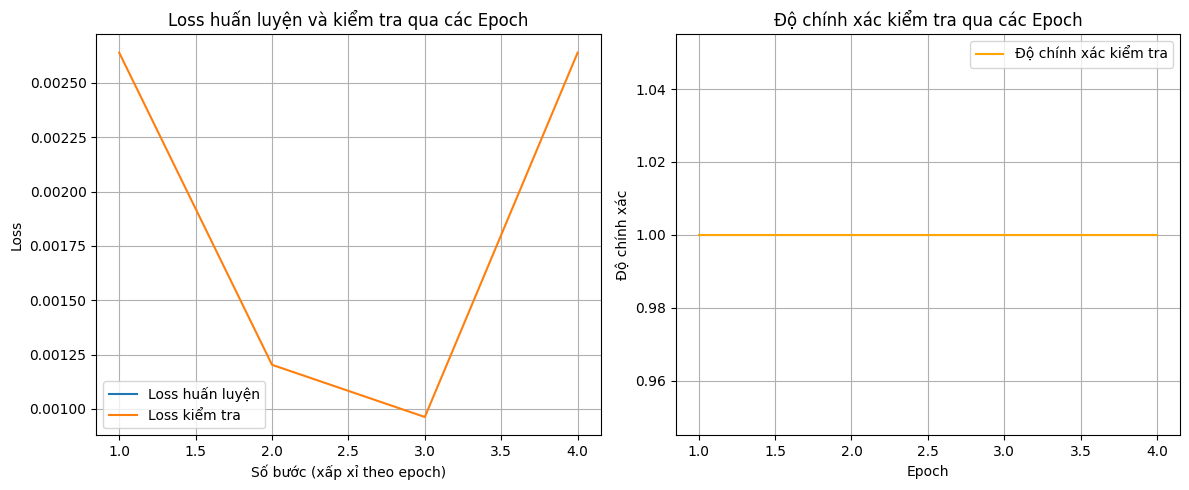


--- Bài tập 2 Hoàn thành ---


In [10]:
# Đánh giá mô hình
print("\nĐang đánh giá mô hình đã tinh chỉnh...")
evaluation_results = trainer.evaluate()
print(f"Kết quả đánh giá: {evaluation_results}")

# Trích xuất dữ liệu cho biểu đồ
train_losses = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_accuracy = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]
epochs = range(1, len(eval_losses) + 1)

# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss huấn luyện')
plt.plot(epochs, eval_losses, label='Loss kiểm tra')
plt.title('Loss huấn luyện và kiểm tra qua các Epoch')
plt.xlabel('Số bước (xấp xỉ theo epoch)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Vẽ biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_accuracy, label='Độ chính xác kiểm tra', color='orange')
plt.title('Độ chính xác kiểm tra qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Độ chính xác')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n--- Bài tập 2 Hoàn thành ---")